<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/neural_ca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq torchinfo

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import tensorflow as tf
import moviepy.editor as mvp
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import Image, HTML, clear_output
from moviepy.editor import VideoClip

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [3]:
def load_image(url, max_size=40):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u{}.png'.format(code)
    return load_image(url)

## Model

In [4]:
CHANNEL_N = 16
TARGET_PADDING = 16
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5
TARGET_EMOJI = "🦎" #@param {type:"string"}

IMAGE_SIZE = TARGET_SIZE + TARGET_PADDING * 2

In [20]:
#@title Model {vertical-output: true}

def padding_same(in_size, kernel_size, stride=1, dilation=1):
    filter_size = (kernel_size - 1) * dilation + 1
    out_size = (in_size + stride - 1) // stride
    return max(0, (out_size - 1) * stride + filter_size - in_size)


def pad_same(x, kernel_size, stride=1):
    """same behavior as padding='SAME' of tensorflow"""
    _, _, h, w = x.size()
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    ph, pw = padding_same(h, kh, sh), padding_same(w, kw, sw)
    hph, hpw = ph // 2, pw // 2
    return F.pad(x, [hpw, hpw + (pw % 2), hph, hph + (ph % 2)])


def depthwise_conv2d(x, kernel, stride=1, dilation=1):
    """same behavior as tf.nn.depthwise_conv2d"""
    cout, cin, kh, kw = kernel.size()
    kernel = kernel.permute(1, 0, 2, 3).reshape(cout * cin, 1, kh, kw)
    return F.conv2d(x, kernel, groups=cin, stride=stride, dilation=dilation)


class NeuralCA(nn.Module):
    def __init__(self, channels=16):
        super().__init__()
        identity = torch.tensor([0.0, 1.0, 0.0])
        identity = torch.outer(identity, identity)
        sobel_x = torch.outer(torch.tensor([1., 2., 1.]), torch.tensor([-1., 0., 1.])) / 8.0
        self.kernel = torch.stack([identity, sobel_x, sobel_x.t()],-1).unsqueeze(2).expand(-1,-1,channels,-1).permute(3,2,0,1)
        
        self.conv1 = nn.Conv2d(channels * 3, 128, 1)
        nn.init.xavier_uniform_(self.conv1.weight.data)
        nn.init.zeros_(self.conv1.bias.data)
        self.conv2 = nn.Conv2d(128, channels, 1)
        nn.init.zeros_(self.conv2.weight.data)
        nn.init.zeros_(self.conv2.bias.data)
        
    def perceive(self, x):
        return depthwise_conv2d(pad_same(x, 3), self.kernel.to(x.device))
    
    def forward(self, x, steps=1.0, thres=0.5):
        pre_mask = F.max_pool2d(x[:,3:4,:,:], 3, stride=1, padding=1) > .1
        
        y = self.perceive(x)
        dx = self.conv2(F.relu(self.conv1(y))) * steps
        dx *= torch.rand((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device) <= thres
        
        x += dx
        
        post_mask = F.max_pool2d(x[:,3:4,:,:], 3, stride=1, padding=1) > .1
        x *= pre_mask & post_mask
        return x

nca = NeuralCA().to(device)
summary(nca, (1,CHANNEL_N,IMAGE_SIZE,IMAGE_SIZE), verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 128, 72, 72]          6,272
├─Conv2d: 1-2                            [1, 16, 72, 72]           2,064
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
Total mult-adds (M): 42.47
Input size (MB): 0.33
Forward/backward pass size (MB): 5.97
Params size (MB): 0.03
Estimated Total Size (MB): 6.34

## Training

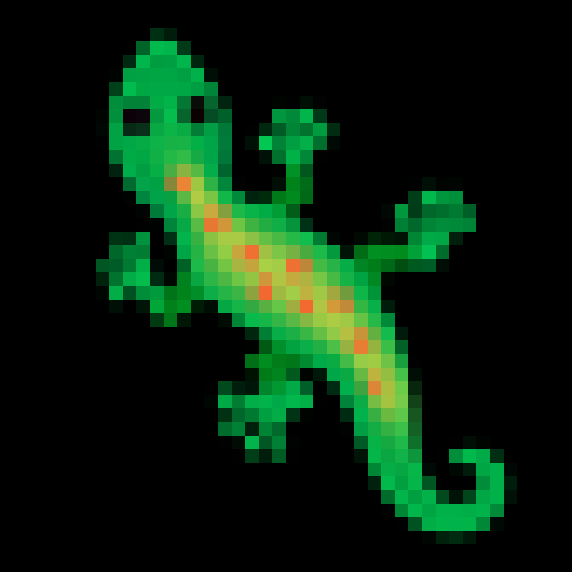

In [6]:
#@title Target Image {vertical-output: true}

def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img

def make_seed(h, w, n=1, channels=CHANNEL_N):
    x = torch.zeros([n, channels, h, w])
    x[:, 3:, h//2, w//2] = 1.0
    return x

def value_noise(dims=(64, 64), batch_size=1, scale=1, mode='bicubic'):
    x = torch.rand((batch_size, 1, dims[0]//scale, dims[1]//scale))
    x = F.interpolate(x, size=[dims[0], dims[1]], mode=mode, align_corners=False)
    return x

def make_circle_masks(h, w, n=1):
    x = torch.linspace(-1.0, 1.0, w).view(1,1,-1)
    y = torch.linspace(-1.0, 1.0, h).view(1,-1,1)
    center = torch.rand(2, n, 1, 1) - 0.5
    r = torch.rand(n, 1, 1) * (0.4 - 0.1) + 0.1
    x, y = (x - center[0]) / r, (y - center[1]) / r
    return (torch.hypot(x, y) < 1.0).type(torch.float32)

target_img = load_emoji(TARGET_EMOJI)
plt.imshow(zoom(target_img, 2))
plt.axis('off')
plt.show()

In [7]:
def plot_loss(losses):
    plt.figure(figsize=(10,4))
    plt.plot(np.log10(losses), '-', alpha=0.8)
    plt.title('Loss history (log10)')
    plt.show()

def plot_pool(pool):
    plt.figure(figsize=(12,6))
    idx = np.random.permutation(np.arange(len(pool)))[:64]
    plt.imshow(make_grid(pool[idx,:3], nrow=16).permute(1,2,0).detach().cpu().numpy().clip(0,1))
    plt.title('Pool')
    plt.axis('off')
    plt.show()

def plot_batch(x0, x):
    plt.figure(figsize=(12,4))
    plt.imshow(make_grid(torch.vstack((x0, x))).detach().cpu().permute(1,2,0)[...,:3].numpy().clip(0,1))
    plt.title('Current Batch (before/after)')
    plt.axis('off')
    plt.show()

def plot_grow(model, x, n=64, every=3):
    _, c, h, w = x.size()
    img = torch.zeros(n, c, h, w)

    for i in range(n * every):
        x = nca(x)
        if i % every == 0:
            img[i//every, :] = x[0].detach().cpu()

    plt.figure(figsize=(12,4))
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0)[...,:3].numpy().clip(0,1))
    plt.title('Growth')
    plt.axis('off')
    plt.show()

In [21]:
loss_log = []

p = TARGET_PADDING
pad_target = F.pad(torch.from_numpy(target_img).permute(2,0,1), (p,p,p,p))

target = pad_target.unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1).to(device)

h, w = pad_target.shape[1:]
seed = make_seed(h, w).to(device)
pool = seed.repeat(POOL_SIZE, 1, 1, 1)

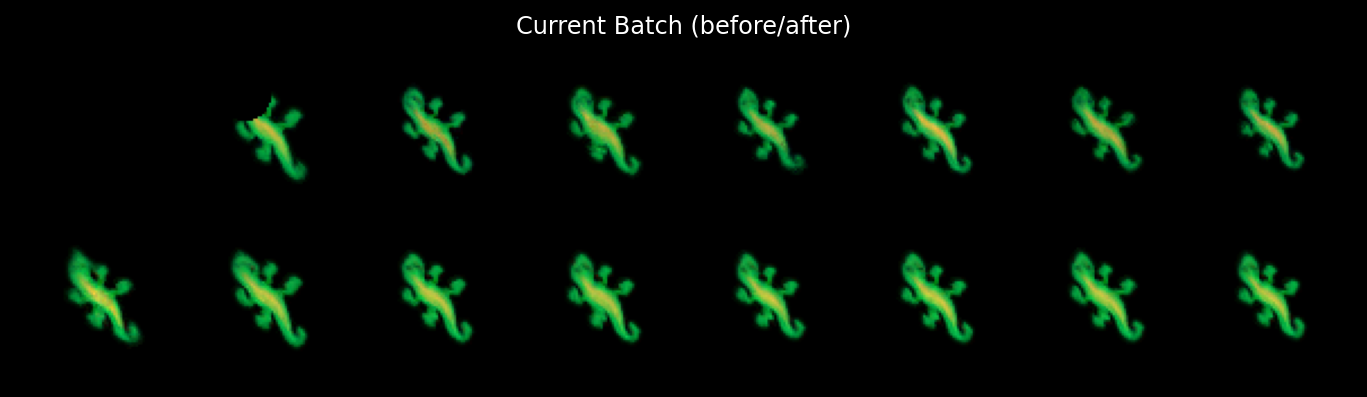

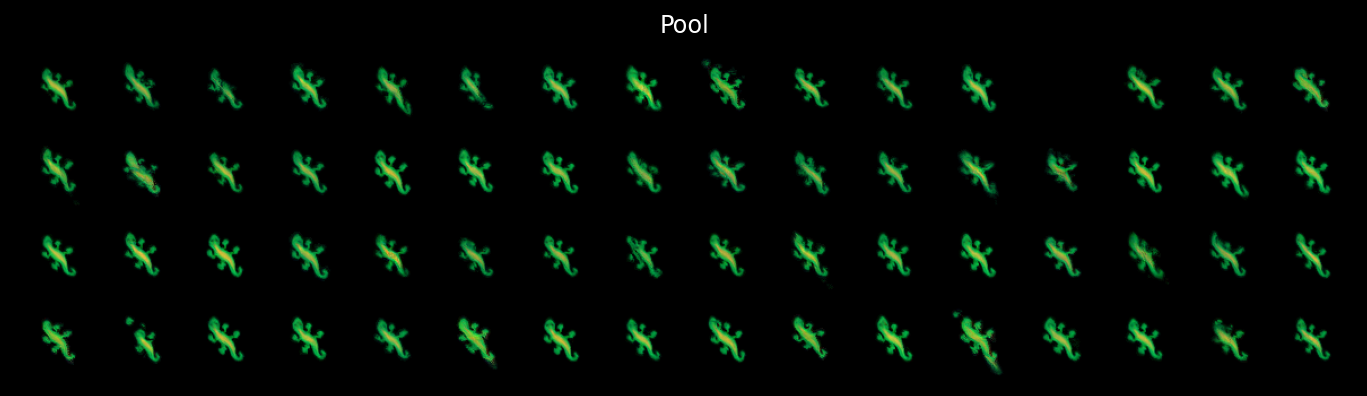

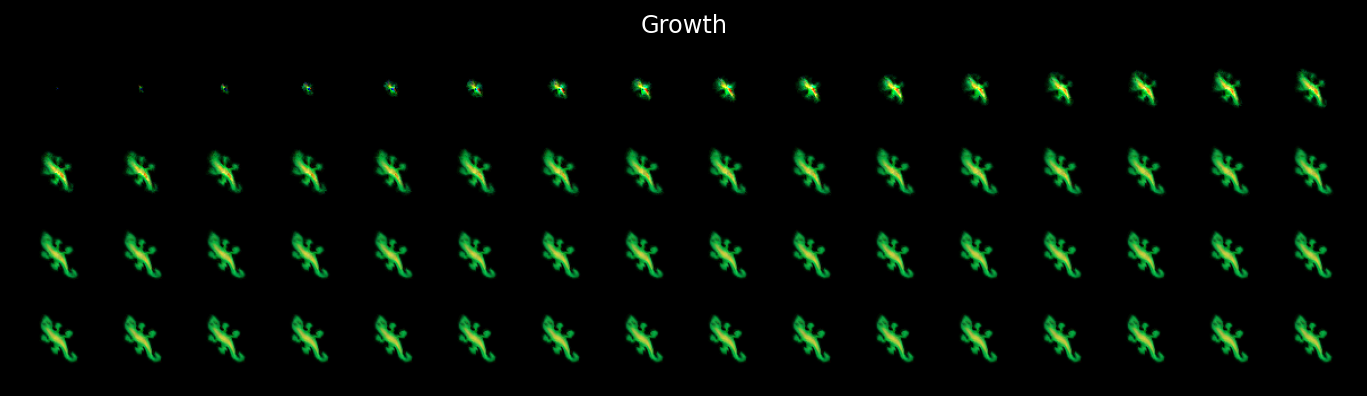

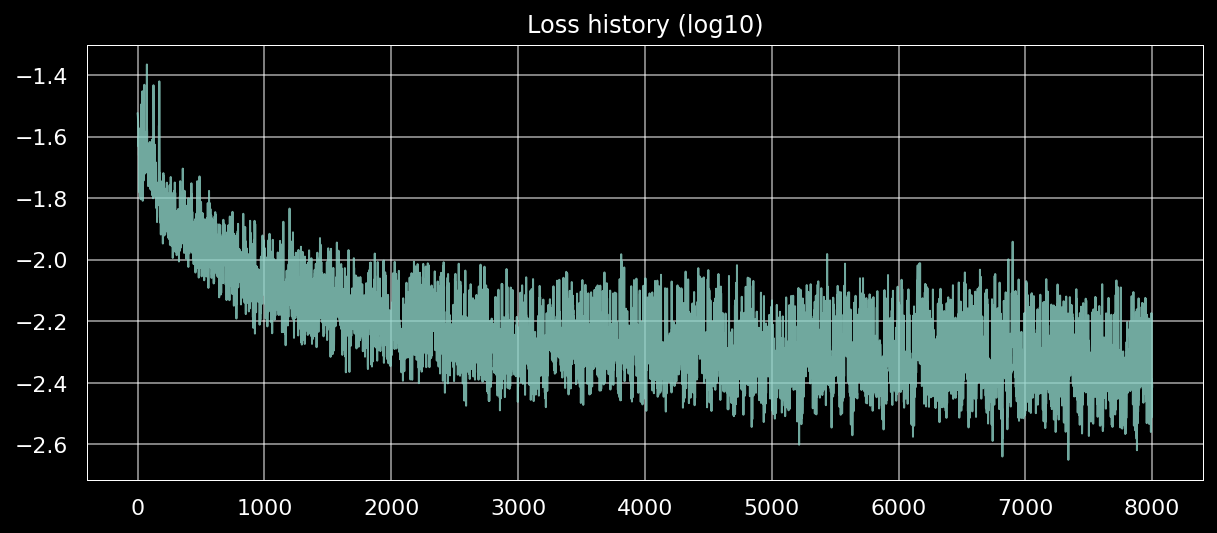

 [8000/8001] elapsed: 1870s, log10(loss): -2.4150

In [22]:
#@title Training Loop {vertical-output: true}

lr = 1e-3

optimizer = torch.optim.Adam(nca.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000], gamma=0.1, verbose=True)

epochs = 8001

start = time.time()

for epoch in range(epochs):
    with torch.no_grad():
        #sample pool
        idx = (torch.rand(BATCH_SIZE) * POOL_SIZE).long()
        state = pool[idx]

        #sort by loss
        sq_error = (state[:, :4, :, :] - target) ** 2
        per_sample_loss = torch.mean(sq_error, [1,2,3])
        sorted_idx = torch.argsort(per_sample_loss)

        #replace worst state with seed
        state[sorted_idx[-1]] = seed

        #damage
        mask = 1.0 - make_circle_masks(h, w, 3).unsqueeze(1)
        state[:3] *= mask.to(device)
        
    state0 = state.clone()
    n_steps = np.random.randint(64, 96)
    for step in range(n_steps):
        state = nca(state)
        
    loss = torch.mean((state[:, :4, :, :] - target) ** 2)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(nca.parameters(), 0.1)
    optimizer.step()

    #return new states to pool
    with torch.no_grad():
        pool[idx] = state

    loss_val = loss.detach().cpu().numpy()
    loss_log.append(loss_val)

    if epoch % 100 == 0:
        clear_output()
        plot_batch(state0, state)
        plot_pool(pool)
        plot_grow(nca, make_seed(h, w).to(device))
        plot_loss(loss_log)

    print("\r [{:2d}/{:2d}] elapsed: {}s, log10(loss): {:.4f}".format(
        epoch, epochs, int(time.time() - start), np.log10(loss_val.item())), end='')

In [28]:
#@title Growth {vertical-output: true}

x = make_seed(h, w).to(device)

def make_frame(t):
    global x
    x = nca(x)
    out = x.detach().cpu()[0].permute(1,2,0)[...,:3].numpy().clip(0,1) * 255.0
    return zoom(out, 2)

animation = VideoClip(make_frame, duration=5)
animation.ipython_display(fps=60, loop=True, autoplay=True)

100%|█████████▉| 300/301 [00:00<00:00, 617.56it/s]
